In [1]:
# Import the necessary libraries

import pandas as pd
from numpy import sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
import datetime
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the CSV and take a peek at the original data

df = pd.read_csv('us_retail_sales.csv')
X=df.values
print('Shape of data \t',df.shape)
print('\n')
print('Original Dataset:\n',df.head())
print('\n')


Shape of data 	 (30, 13)


Original Dataset:
    YEAR     JAN     FEB     MAR     APR     MAY     JUN       JUL       AUG  \
0  1992  146925  147223  146805  148032  149010  149800  150761.0  151067.0   
1  1993  157555  156266  154752  158979  160605  160127  162816.0  162506.0   
2  1994  167518  169649  172766  173106  172329  174241  174781.0  177295.0   
3  1995  182413  179488  181013  181686  183536  186081  185431.0  186806.0   
4  1996  189135  192266  194029  194744  196205  196136  196187.0  196218.0   

        SEP       OCT       NOV       DEC  
0  152588.0  153521.0  153583.0  155614.0  
1  163258.0  164685.0  166594.0  168161.0  
2  178787.0  180561.0  180703.0  181524.0  
3  187366.0  186565.0  189055.0  190774.0  
4  198859.0  200509.0  200174.0  201284.0  




In [3]:
# Use the melt function in pandas to lengthen the dataframe into a few columns instead of 12
# Then replace the month abbreviation with a numerical values to be able to create a correct datetime column

df2 = pd.melt(df, id_vars=['YEAR'], var_name="MONTH", value_name="SALES")
df2['Month'] = df2['MONTH'].map({'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4,'MAY':5,'JUN':6,'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12})

In [4]:
df2['DATE']=pd.to_datetime(df2[['YEAR','Month']].assign(DAY=1))

In [5]:
# New dataframe with numerical month and year, after assigning each row to have '1' for the day
df2

,YEAR,MONTH,SALES,Month,DATE
0,1992,JAN,146925.0,1,1992-01-01
1,1993,JAN,157555.0,1,1993-01-01
2,1994,JAN,167518.0,1,1994-01-01
3,1995,JAN,182413.0,1,1995-01-01
4,1996,JAN,189135.0,1,1996-01-01
...,...,...,...,...,...
355,2017,DEC,433282.0,12,2017-12-01
356,2018,DEC,434803.0,12,2018-12-01
357,2019,DEC,458055.0,12,2019-12-01
358,2020,DEC,484782.0,12,2020-12-01


In [6]:
# create a 3rd dataframe with just the columns I need (date and sales amount).

df_clean = df2[['DATE','SALES']].sort_values('DATE')
df_clean = df_clean.dropna()
datetime_index = pd.DatetimeIndex(df_clean['DATE'].values)
df_clean = df_clean.set_index(datetime_index)
df_clean.drop('DATE', axis=1, inplace=True)
df_clean

,SALES
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0
...,...
2021-02-01,504458.0
2021-03-01,559871.0
2021-04-01,562269.0
2021-05-01,548987.0


## Plot the data with proper labeling and make some observations on the graph 

Text(0, 0.5, 'Sales in $')

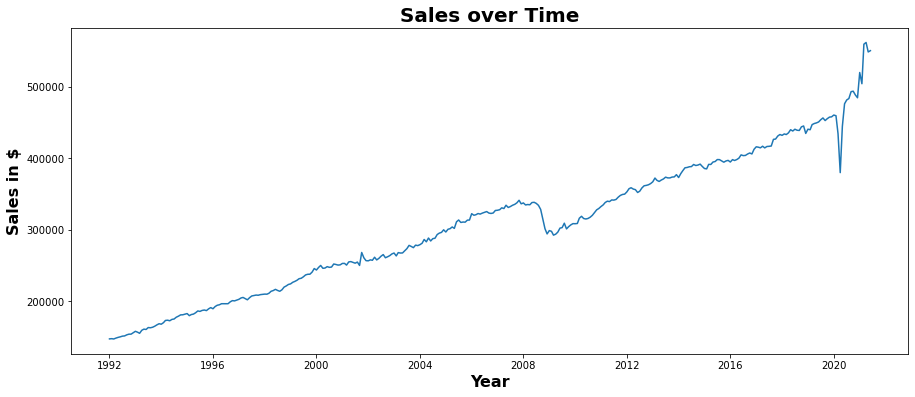

In [7]:
fig, ax = plt.subplots(figsize=(15,6))
date=df_clean.index
sales = df_clean['SALES']
sns.lineplot(date, sales)

ax.set_title('Sales over Time', fontsize=20, loc='center',fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales in $', fontsize=16, fontdict=dict(weight='bold'))

In [8]:
# fig = plt.figure(figsize=(12,8))
# plt.plot(date, sales, label='Sales in $', linewidth=3)

# plt.title('Sales by Month')
# plt.xlabel('Date')
# plt.ylabel('Sales in $')
# plt.tight_layout()
# plt.show()

#### Observations from the graph of the sales data:

#### It seems to have a rather linear growth trend from 1992 on, with slight dips/spikes. Early 2008 there was a drop, but sales appearred to have recovered and continued on the pre-2008 trend. Early 2020 there was a drastic dip followed by an immediate recovery. Sales late into 2020 and early 2021 appear to be outperforming the linear growth line from previous years

## Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [9]:
train_df = df_clean[df_clean.index < '2020-07-01']
test_df = df_clean[df_clean.index >= '2020-07-01']

In [10]:
train_df

,SALES
1992-01-01,146925.0
1992-02-01,147223.0
1992-03-01,146805.0
1992-04-01,148032.0
1992-05-01,149010.0
...,...
2020-02-01,459610.0
2020-03-01,434281.0
2020-04-01,379892.0
2020-05-01,444631.0


In [11]:
test_df

,SALES
2020-07-01,481627.0
2020-08-01,483716.0
2020-09-01,493327.0
2020-10-01,493991.0
2020-11-01,488652.0
2020-12-01,484782.0
2021-01-01,520162.0
2021-02-01,504458.0
2021-03-01,559871.0
2021-04-01,562269.0


## Use the training set to build a predictive model for the monthly retail sales.

In [27]:
model=AutoReg(train_df,lags=5).fit()

In [28]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  SALES   No. Observations:                  342
Model:                     AutoReg(5)   Log Likelihood               -3375.942
Method:               Conditional MLE   S.D. of innovations           5424.567
Date:                Sun, 08 May 2022   AIC                             17.239
Time:                        12:26:12   BIC                             17.318
Sample:                    06-01-1992   HQIC                            17.271
                         - 06-01-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2180.0628   1089.933      2.000      0.045      43.833    4316.293
SALES.L1       0.8523      0.055     15.449      0.000       0.744       0.960
SALES.L2      -0.3524      0.080     -4.407      0.0

## Use the model to predict the monthly retail sales on the last year of data.

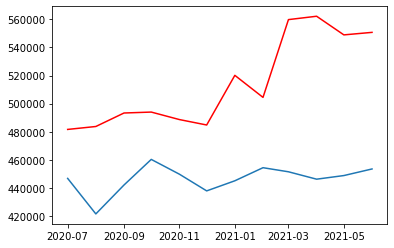

In [29]:
pred = model.predict(start=len(train_df), end=(len(df_clean)-1),dynamic=False)

plt.plot(pred)
plt.plot(test_df, color='red')

## Report the RMSE of the model predictions on the test set.

In [30]:
rmse = sqrt(mean_squared_error(X_test, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 73875.521


### This RMSE seems extraordinarily high, so I wanted to try ARIMA instead

In [31]:
stepwise_fit = auto_arima(df_clean['SALES'], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7243.088, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7239.602, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7239.698, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7239.588, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7247.358, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7242.471, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7239.141, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7240.909, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7241.296, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7241.528, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=7249.210, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 0.675 seconds


In [32]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  354
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -3615.571
Date:                Sun, 08 May 2022   AIC                           7239.141
Time:                        12:26:58   BIC                           7254.607
Sample:                             0   HQIC                          7245.295
                                - 354                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1511.5750    370.450      4.080      0.000     785.507    2237.643
ma.L1         -0.0614      0.012     -4.914      0.000      -0.086      -0.037
ma.L2         -0.0655      0.014     -4.608      0.000      -0.093      -0.038
sigma2       4.63e+07      0.027   1.72e+09      0.000    4.63e+07    4.63e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):             28188.12
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):              17.47   Skew:                             1.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.74e+23. Standard errors may be unstable.
"""

In [33]:
model=ARIMA(train_df, order=(0,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  SALES   No. Observations:                  342
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3442.577
Date:                Sun, 08 May 2022   AIC                           6891.154
Time:                        12:27:04   BIC                           6902.649
Sample:                    01-01-1992   HQIC                          6895.734
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0078      0.009     -0.914      0.361      -0.025       0.009
ma.L2         -0.1056      0.012     -9.045      0.000      -0.129      -0.083
sigma2      3.283e+07   1.06e-10    3.1e+17      0.000    3.28e+07    3.28e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):             54682.79
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):              15.01   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.25e+31. Standard errors may be unstable.
"""

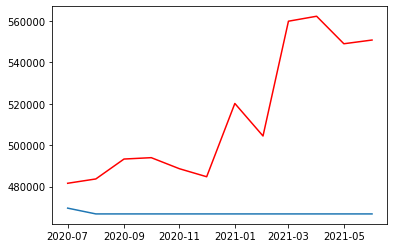

In [34]:
pred = model.predict(start=len(train_df), end=(len(df_clean)-1),dynamic=False)

plt.plot(pred)
plt.plot(X_test, color='red')

In [35]:
rmse = sqrt(mean_squared_error(X_test, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 56632.332
